In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
"""
0: background,
1: sacrum,
2: right_hip,
3: left_hip,
4: lumbar_vertebra.        
"""        

'\n0: background,\n1: sacrum,\n2: right_hip,\n3: left_hip,\n4: lumbar_vertebra.        \n'

In [3]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    Resized,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    Activationsd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ScaleIntensityd,
    SaveImaged,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from monai.optimizers import Novograd
from monai.utils import get_torch_version_tuple, set_determinism
from ignite.handlers import EarlyStopping, ModelCheckpoint

print_config()


MONAI version: 0.9.dev2209
Numpy version: 1.21.5
Pytorch version: 1.10.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 9db6e543d6090a3256f20695c1d3224df8cbbc0e
MONAI __file__: C:\Users\Hripsime\anaconda3\envs\abys\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.1
Pillow version: 8.4.0
Tensorboard version: 2.8.0
gdown version: 4.2.1
TorchVision version: 0.11.3
tqdm version: 4.62.3
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.4.1
einops version: 0.4.0
transformers version: 4.16.2
mlflow version: 1.23.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

In [4]:
root_dir  = '../projects/CTPelvic1K_data/'

data_image = os.path.join(root_dir, 'images')
data_mask = os.path.join(root_dir, 'masks')


## Set dataset path

In [5]:
train_images = sorted(glob.glob(os.path.join(data_image, "*data.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_mask, "*mask_4label.nii.gz")))

data_dicts = [ {"image": image_name, "mask": label_name} for image_name, label_name in zip(train_images, train_labels) ]
train_files, val_files = data_dicts[:-10], data_dicts[-10:]

In [6]:
set_determinism(seed=0)

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),
        Orientationd(keys=["image", "mask"], axcodes="RAS"),
        Spacingd(keys=["image", "mask"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=-120, a_max=360,b_min=0.0, b_max=1.0, clip=True,),
        CropForegroundd(keys=["image", "mask"], source_key="image"),
        #DataStatsd(keys=["image", "label"], prefix='Data', data_type=True, data_shape=True, value_range=True, data_value=False),
        
        RandCropByPosNegLabeld(
            keys=["image", "mask"],
            label_key="mask",
            spatial_size=(128, 128, 128),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        
        EnsureTyped(keys=["image", "mask"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),
        Orientationd(keys=["image", "mask"], axcodes="RAS"),
        Spacingd(keys=["image", "mask"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=-120, a_max=360,b_min=0.0, b_max=1.0, clip=True,),
        CropForegroundd(keys=["image", "mask"], source_key="image"),
        EnsureTyped(keys=["image", "mask"]),
    ]
)



In [8]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=0)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)


Loading dataset: 100%|█████████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.81s/it]


image shape: torch.Size([372, 234, 261]), mask shape: torch.Size([372, 234, 261])


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 432x288 with 0 Axes>

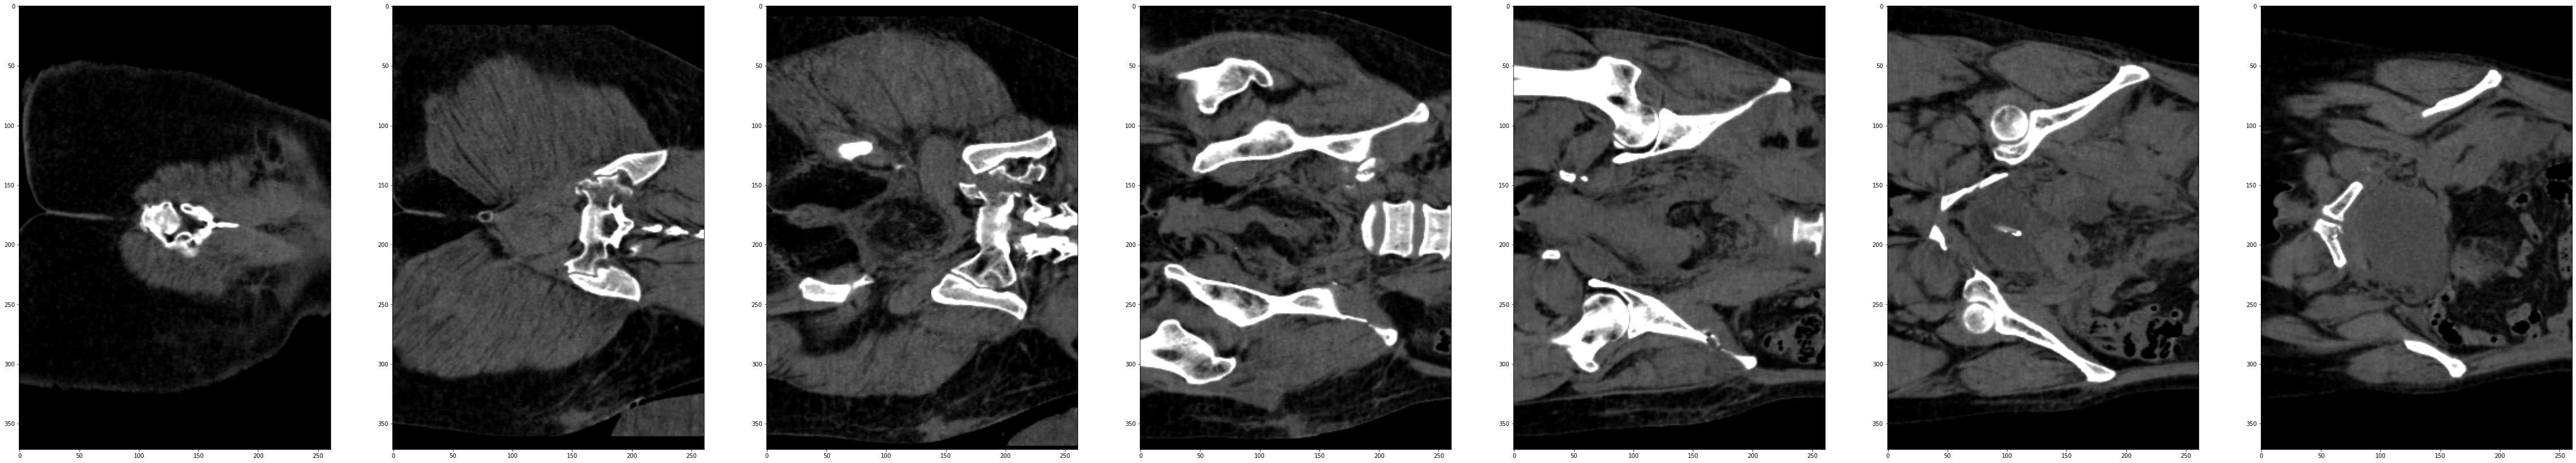

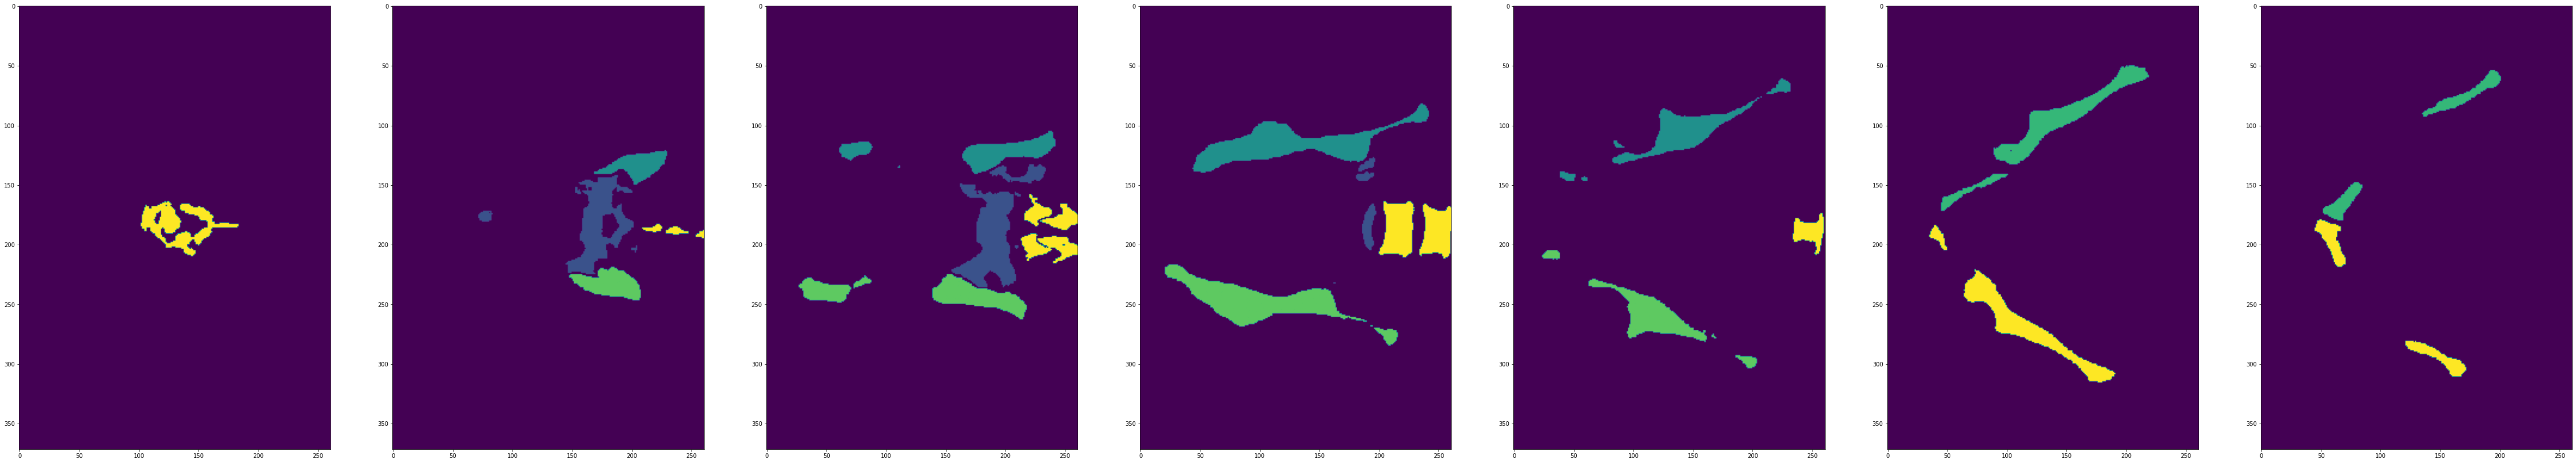

In [9]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["mask"][0][0])
print(f"image shape: {image.shape}, mask shape: {label.shape}")


fig = plt.figure()
fig, (ax1, ax2 ,ax3, ax4, ax5, ax6, ax7) = plt.subplots(nrows=1, ncols=7, figsize=(80, 50))
fig, (ax8, ax9, ax10, ax11, ax12, ax13, ax14) = plt.subplots(nrows=1, ncols=7, figsize=(80, 50))

ax1.imshow(image[:, 60, :], cmap="gray")
ax2.imshow(image[:, 80, :], cmap="gray")
ax3.imshow(image[:, 100, :], cmap="gray")
ax4.imshow(image[:, 120, :], cmap="gray")
ax5.imshow(image[:, 140, :], cmap="gray")
ax6.imshow(image[:, 160, :], cmap="gray")
ax7.imshow(image[:, 180, :], cmap="gray")

ax8.imshow(label[:, 60, :])
ax9.imshow(label[:, 80, :])
ax10.imshow(label[:, 100, :])
ax11.imshow(label[:, 120, :])
ax12.imshow(label[:, 140, :])
ax13.imshow(label[:, 160, :])
ax14.imshow(label[:, 180, :])

plt.show

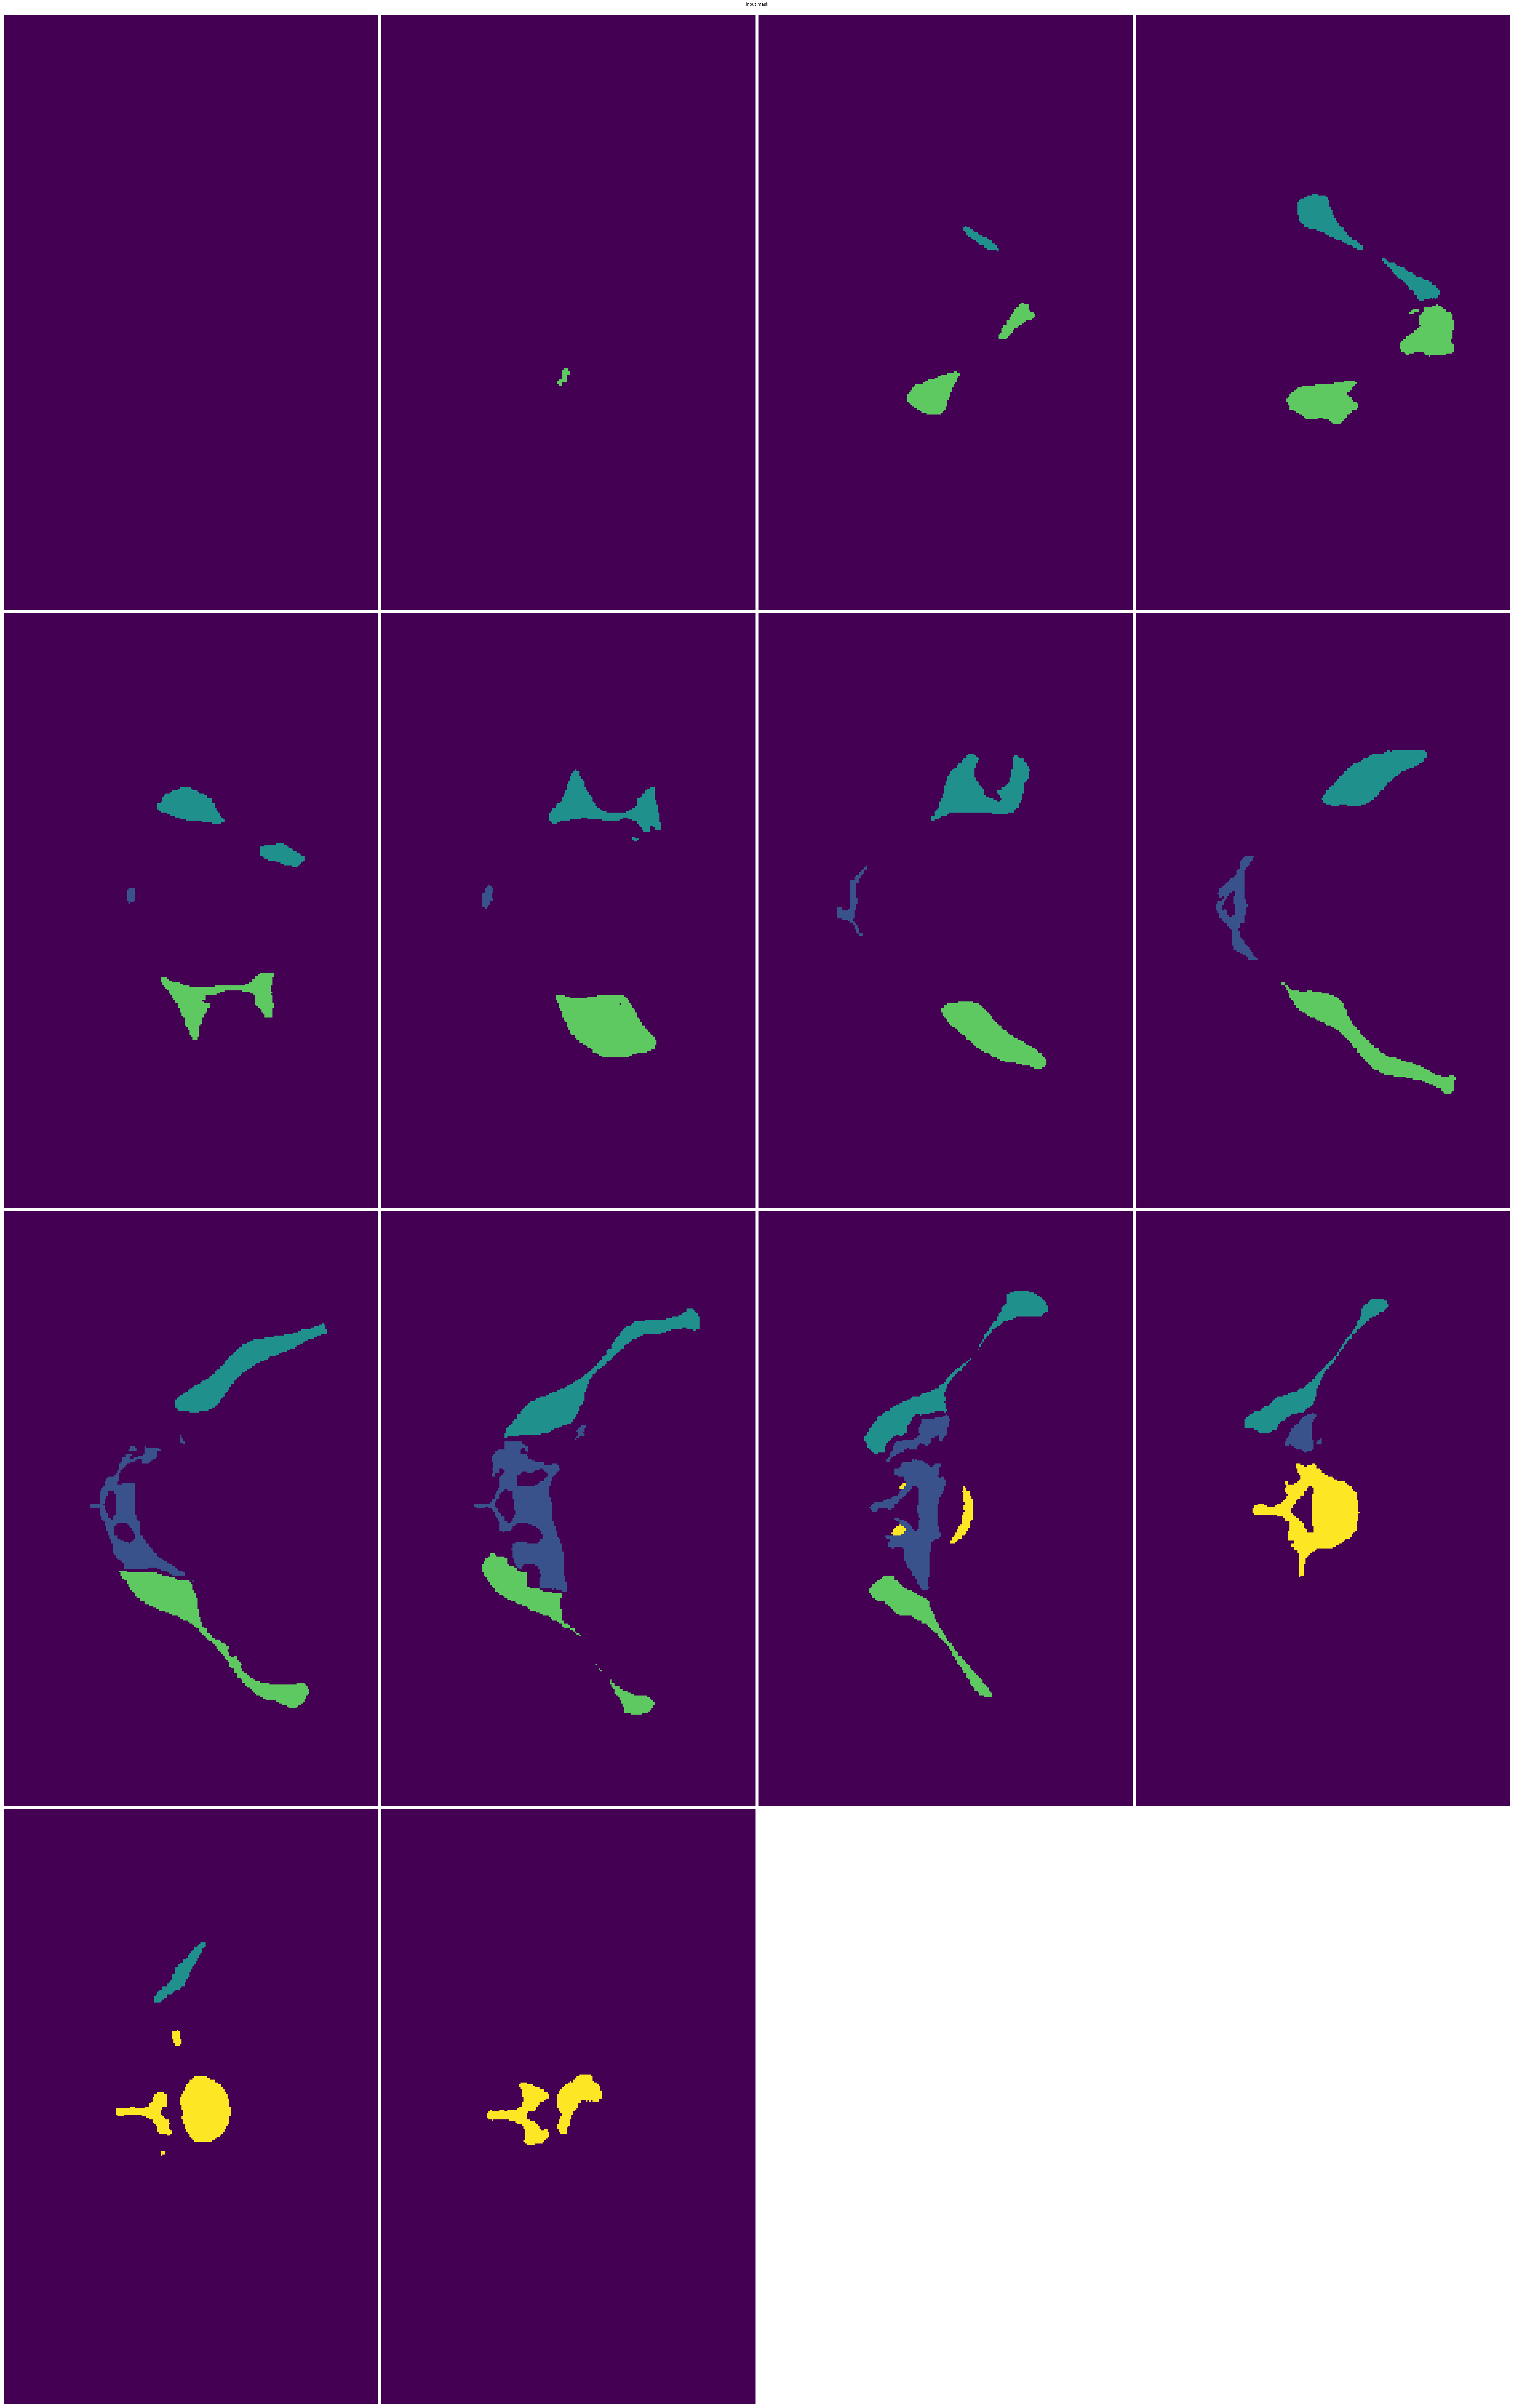

(<Figure size 7200x7200 with 1 Axes>,
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        ...,
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32))

In [10]:
from monai.visualize import blend_images, matshow3d, plot_2d_or_3d_image

matshow3d(volume=check_data['mask'], fig=None, title="input mask", figsize=(100, 100), every_n=20, frame_dim=-1,show=True,)
#cmap="gray",

In [11]:
ret = blend_images(image=check_data["image"][0], label=check_data["mask"][0], alpha=0.5, cmap="hsv", rescale_arrays=False)
print(ret.shape)

torch.Size([3, 372, 234, 261])


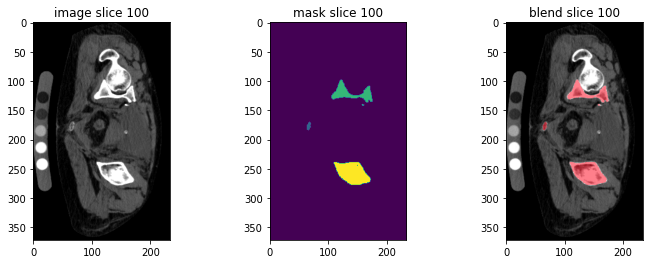

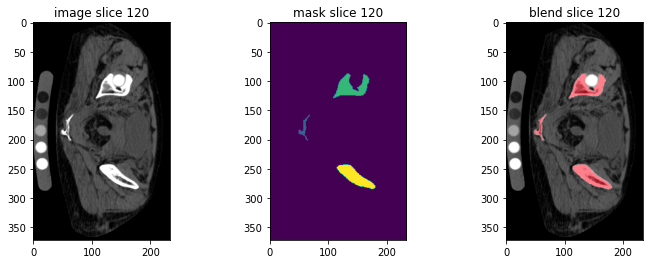

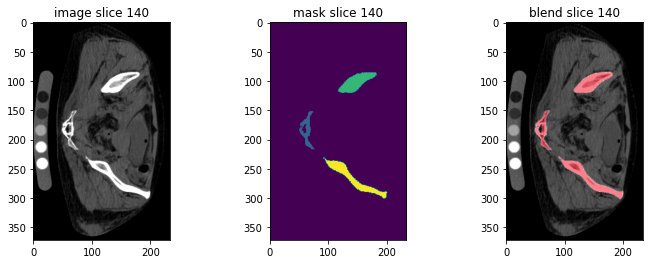

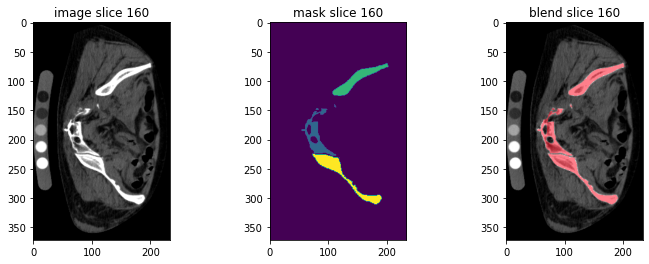

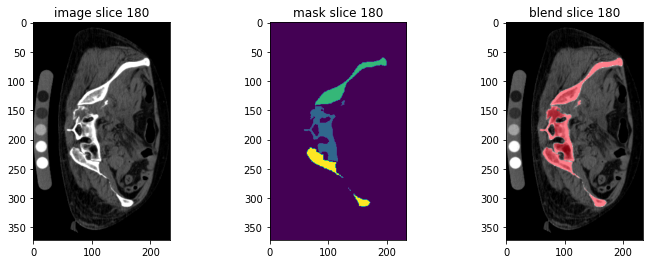

In [12]:
for i in range(5, 10):
    # plot the slice 50 - 100 of image, label and blend result
    slice_index = 20 * i
    plt.figure("blend image and mask", (12, 4))
    plt.subplot(1, 3, 1)
    plt.title(f"image slice {slice_index}")
    plt.imshow(check_data["image"][0, 0, :, :, slice_index], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title(f"mask slice {slice_index}")
    plt.imshow(check_data["mask"][0, 0, :, :, slice_index])
    plt.subplot(1, 3, 3)
    plt.title(f"blend slice {slice_index}")
    # switch the channel dim to the last dim
    plt.imshow(torch.moveaxis(ret[:, :, :, slice_index], 0, -1))
    plt.show()

In [13]:
import gc #garbage collector
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

## Create Model, Loss, Optimizer

In [14]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer

VAL_AMP = True #Automatic mixed precision to accelerate training speed and reduce a memory usage
learning_rate = 2e-4

device=torch.device("cuda:0")     
#device=torch.device("cpu")      
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=5,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
#loss_function = DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=True, batch=True) 

optimizer = torch.optim.Adam(model.parameters(), learning_rate)
#optimizer = Novograd(model.parameters(), learning_rate * 10)
dice_metric = DiceMetric(include_background=False, reduction="mean")


# define inference method
def inference(input):

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(160, 160, 160),
            sw_batch_size=4,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)
    
# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True    

## Execute a typical PyTorch training process

In [15]:
max_epochs = 400
val_interval = 1
best_metric = -1
best_metric_epoch = -1

epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=5)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=5)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["mask"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["mask"].to(device),
                )
                
                val_outputs = inference(val_inputs)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/400
1/31, train_loss: 0.8958
2/31, train_loss: 0.9034
3/31, train_loss: 0.9020
4/31, train_loss: 0.8811
5/31, train_loss: 0.9092
6/31, train_loss: 0.8727
7/31, train_loss: 0.8824
8/31, train_loss: 0.8790
9/31, train_loss: 0.8735
10/31, train_loss: 0.8749
11/31, train_loss: 0.8622
12/31, train_loss: 0.8683
13/31, train_loss: 0.8650
14/31, train_loss: 0.8620
15/31, train_loss: 0.8692
16/31, train_loss: 0.8734
17/31, train_loss: 0.8692
18/31, train_loss: 0.8479
19/31, train_loss: 0.8556
20/31, train_loss: 0.8527
21/31, train_loss: 0.8359
22/31, train_loss: 0.8721
23/31, train_loss: 0.8148
24/31, train_loss: 0.8650
25/31, train_loss: 0.8666
26/31, train_loss: 0.8473
27/31, train_loss: 0.8596
28/31, train_loss: 0.8216
29/31, train_loss: 0.8350
30/31, train_loss: 0.8622
31/31, train_loss: 0.8365
epoch 1 average loss: 0.8650
saved new best metric model
current epoch: 1 current mean dice: 0.1168
best mean dice: 0.1168 at epoch: 1
----------
epoch 2/400
1/31, train_loss: 0.81

22/31, train_loss: 0.5486
23/31, train_loss: 0.5911
24/31, train_loss: 0.5155
25/31, train_loss: 0.5517
26/31, train_loss: 0.6541
27/31, train_loss: 0.4992
28/31, train_loss: 0.5979
29/31, train_loss: 0.5695
30/31, train_loss: 0.4886
31/31, train_loss: 0.5920
epoch 9 average loss: 0.5839
saved new best metric model
current epoch: 9 current mean dice: 0.4797
best mean dice: 0.4797 at epoch: 9
----------
epoch 10/400
1/31, train_loss: 0.5392
2/31, train_loss: 0.6322
3/31, train_loss: 0.6671
4/31, train_loss: 0.5369
5/31, train_loss: 0.5977
6/31, train_loss: 0.5391
7/31, train_loss: 0.5742
8/31, train_loss: 0.5926
9/31, train_loss: 0.6011
10/31, train_loss: 0.6121
11/31, train_loss: 0.4655
12/31, train_loss: 0.6864
13/31, train_loss: 0.4761
14/31, train_loss: 0.5170
15/31, train_loss: 0.5849
16/31, train_loss: 0.5960
17/31, train_loss: 0.5764
18/31, train_loss: 0.4704
19/31, train_loss: 0.5047
20/31, train_loss: 0.6387
21/31, train_loss: 0.5320
22/31, train_loss: 0.4875
23/31, train_loss:

9/31, train_loss: 0.6954
10/31, train_loss: 0.3828
11/31, train_loss: 0.3758
12/31, train_loss: 0.4723
13/31, train_loss: 0.3820
14/31, train_loss: 0.3446
15/31, train_loss: 0.3161
16/31, train_loss: 0.5007
17/31, train_loss: 0.4094
18/31, train_loss: 0.4483
19/31, train_loss: 0.4207
20/31, train_loss: 0.4849
21/31, train_loss: 0.4620
22/31, train_loss: 0.3605
23/31, train_loss: 0.5186
24/31, train_loss: 0.3020
25/31, train_loss: 0.4895
26/31, train_loss: 0.2954
27/31, train_loss: 0.3677
28/31, train_loss: 0.4205
29/31, train_loss: 0.4704
30/31, train_loss: 0.5731
31/31, train_loss: 0.4579
epoch 18 average loss: 0.4432
saved new best metric model
current epoch: 18 current mean dice: 0.7220
best mean dice: 0.7220 at epoch: 18
----------
epoch 19/400
1/31, train_loss: 0.3841
2/31, train_loss: 0.5334
3/31, train_loss: 0.3637
4/31, train_loss: 0.3765
5/31, train_loss: 0.4982
6/31, train_loss: 0.3992
7/31, train_loss: 0.2926
8/31, train_loss: 0.3483
9/31, train_loss: 0.3904
10/31, train_los

1/31, train_loss: 0.2044
2/31, train_loss: 0.5020
3/31, train_loss: 0.3668
4/31, train_loss: 0.5109
5/31, train_loss: 0.3155
6/31, train_loss: 0.4469
7/31, train_loss: 0.3424
8/31, train_loss: 0.3834
9/31, train_loss: 0.3339
10/31, train_loss: 0.3417
11/31, train_loss: 0.3550
12/31, train_loss: 0.2872
13/31, train_loss: 0.2379
14/31, train_loss: 0.3127
15/31, train_loss: 0.6282
16/31, train_loss: 0.3463
17/31, train_loss: 0.4206
18/31, train_loss: 0.2103
19/31, train_loss: 0.3316
20/31, train_loss: 0.3996
21/31, train_loss: 0.4738
22/31, train_loss: 0.3643
23/31, train_loss: 0.2661
24/31, train_loss: 0.5928
25/31, train_loss: 0.6134
26/31, train_loss: 0.4040
27/31, train_loss: 0.2892
28/31, train_loss: 0.2535
29/31, train_loss: 0.3573
30/31, train_loss: 0.4256
31/31, train_loss: 0.4967
epoch 27 average loss: 0.3811
current epoch: 27 current mean dice: 0.7571
best mean dice: 0.8110 at epoch: 26
----------
epoch 28/400
1/31, train_loss: 0.3437
2/31, train_loss: 0.3612
3/31, train_loss: 0

28/31, train_loss: 0.4620
29/31, train_loss: 0.4316
30/31, train_loss: 0.2485
31/31, train_loss: 0.4502
epoch 35 average loss: 0.3826
current epoch: 35 current mean dice: 0.8730
best mean dice: 0.8772 at epoch: 34
----------
epoch 36/400
1/31, train_loss: 0.4479
2/31, train_loss: 0.2484
3/31, train_loss: 0.2077
4/31, train_loss: 0.2526
5/31, train_loss: 0.3524
6/31, train_loss: 0.3039
7/31, train_loss: 0.2190
8/31, train_loss: 0.3622
9/31, train_loss: 0.4922
10/31, train_loss: 0.1997
11/31, train_loss: 0.2673
12/31, train_loss: 0.3261
13/31, train_loss: 0.3257
14/31, train_loss: 0.3595
15/31, train_loss: 0.3953
16/31, train_loss: 0.4074
17/31, train_loss: 0.4953
18/31, train_loss: 0.3331
19/31, train_loss: 0.3449
20/31, train_loss: 0.2210
21/31, train_loss: 0.3235
22/31, train_loss: 0.4918
23/31, train_loss: 0.5381
24/31, train_loss: 0.3819
25/31, train_loss: 0.3054
26/31, train_loss: 0.2477
27/31, train_loss: 0.4533
28/31, train_loss: 0.3311
29/31, train_loss: 0.2470
30/31, train_loss

18/31, train_loss: 0.3859
19/31, train_loss: 0.2433
20/31, train_loss: 0.4096
21/31, train_loss: 0.2665
22/31, train_loss: 0.3992
23/31, train_loss: 0.3059
24/31, train_loss: 0.3362
25/31, train_loss: 0.4172
26/31, train_loss: 0.4783
27/31, train_loss: 0.3961
28/31, train_loss: 0.4410
29/31, train_loss: 0.3021
30/31, train_loss: 0.4444
31/31, train_loss: 0.3519
epoch 44 average loss: 0.3659
current epoch: 44 current mean dice: 0.8618
best mean dice: 0.8994 at epoch: 40
----------
epoch 45/400
1/31, train_loss: 0.3310
2/31, train_loss: 0.3997
3/31, train_loss: 0.2647
4/31, train_loss: 0.2700
5/31, train_loss: 0.3240
6/31, train_loss: 0.3483
7/31, train_loss: 0.3834
8/31, train_loss: 0.3097
9/31, train_loss: 0.3355
10/31, train_loss: 0.3600
11/31, train_loss: 0.5288
12/31, train_loss: 0.3815
13/31, train_loss: 0.2155
14/31, train_loss: 0.4492
15/31, train_loss: 0.5650
16/31, train_loss: 0.3793
17/31, train_loss: 0.3593
18/31, train_loss: 0.4489
19/31, train_loss: 0.3045
20/31, train_loss

9/31, train_loss: 0.2979
10/31, train_loss: 0.3802
11/31, train_loss: 0.4315
12/31, train_loss: 0.2895
13/31, train_loss: 0.4731
14/31, train_loss: 0.5356
15/31, train_loss: 0.4287
16/31, train_loss: 0.4425
17/31, train_loss: 0.3026
18/31, train_loss: 0.1933
19/31, train_loss: 0.4358
20/31, train_loss: 0.4564
21/31, train_loss: 0.4232
22/31, train_loss: 0.3665
23/31, train_loss: 0.4275
24/31, train_loss: 0.4758
25/31, train_loss: 0.2554
26/31, train_loss: 0.3841
27/31, train_loss: 0.4671
28/31, train_loss: 0.2041
29/31, train_loss: 0.4170
30/31, train_loss: 0.3938
31/31, train_loss: 0.2907
epoch 53 average loss: 0.3762
current epoch: 53 current mean dice: 0.9054
best mean dice: 0.9194 at epoch: 47
----------
epoch 54/400
1/31, train_loss: 0.5422
2/31, train_loss: 0.2994
3/31, train_loss: 0.5350
4/31, train_loss: 0.3483
5/31, train_loss: 0.2890
6/31, train_loss: 0.3074
7/31, train_loss: 0.4396
8/31, train_loss: 0.3481
9/31, train_loss: 0.4805
10/31, train_loss: 0.4315
11/31, train_loss:

1/31, train_loss: 0.1748
2/31, train_loss: 0.1845
3/31, train_loss: 0.2981
4/31, train_loss: 0.1923
5/31, train_loss: 0.2428
6/31, train_loss: 0.2300
7/31, train_loss: 0.1395
8/31, train_loss: 0.5162
9/31, train_loss: 0.3389
10/31, train_loss: 0.2882
11/31, train_loss: 0.2791
12/31, train_loss: 0.2757
13/31, train_loss: 0.3081
14/31, train_loss: 0.3920
15/31, train_loss: 0.4177
16/31, train_loss: 0.3499
17/31, train_loss: 0.3811
18/31, train_loss: 0.3388
19/31, train_loss: 0.3406
20/31, train_loss: 0.3882
21/31, train_loss: 0.3625
22/31, train_loss: 0.3859
23/31, train_loss: 0.3690
24/31, train_loss: 0.2559
25/31, train_loss: 0.1824
26/31, train_loss: 0.4785
27/31, train_loss: 0.4430
28/31, train_loss: 0.4008
29/31, train_loss: 0.3151
30/31, train_loss: 0.3402
31/31, train_loss: 0.2974
epoch 62 average loss: 0.3196
current epoch: 62 current mean dice: 0.9259
best mean dice: 0.9333 at epoch: 58
----------
epoch 63/400
1/31, train_loss: 0.4585
2/31, train_loss: 0.4543
3/31, train_loss: 0

29/31, train_loss: 0.3204
30/31, train_loss: 0.3269
31/31, train_loss: 0.1899
epoch 70 average loss: 0.3446
current epoch: 70 current mean dice: 0.9393
best mean dice: 0.9396 at epoch: 67
----------
epoch 71/400
1/31, train_loss: 0.3456
2/31, train_loss: 0.2509
3/31, train_loss: 0.2017
4/31, train_loss: 0.5050
5/31, train_loss: 0.2898
6/31, train_loss: 0.2941
7/31, train_loss: 0.4741
8/31, train_loss: 0.3107
9/31, train_loss: 0.3240
10/31, train_loss: 0.2889
11/31, train_loss: 0.4196
12/31, train_loss: 0.2830
13/31, train_loss: 0.2786
14/31, train_loss: 0.4864
15/31, train_loss: 0.6200
16/31, train_loss: 0.4219
17/31, train_loss: 0.1843
18/31, train_loss: 0.2376
19/31, train_loss: 0.5099
20/31, train_loss: 0.3263
21/31, train_loss: 0.3781
22/31, train_loss: 0.1961
23/31, train_loss: 0.2899
24/31, train_loss: 0.4061
25/31, train_loss: 0.1944
26/31, train_loss: 0.2789
27/31, train_loss: 0.3977
28/31, train_loss: 0.4857
29/31, train_loss: 0.2925
30/31, train_loss: 0.3584
31/31, train_loss

21/31, train_loss: 0.4442
22/31, train_loss: 0.3934
23/31, train_loss: 0.4288
24/31, train_loss: 0.3295
25/31, train_loss: 0.3004
26/31, train_loss: 0.3318
27/31, train_loss: 0.5230
28/31, train_loss: 0.1838
29/31, train_loss: 0.4345
30/31, train_loss: 0.2831
31/31, train_loss: 0.4453
epoch 79 average loss: 0.3301
current epoch: 79 current mean dice: 0.8747
best mean dice: 0.9435 at epoch: 74
----------
epoch 80/400
1/31, train_loss: 0.3829
2/31, train_loss: 0.3021
3/31, train_loss: 0.4113
4/31, train_loss: 0.3197
5/31, train_loss: 0.3317
6/31, train_loss: 0.2815
7/31, train_loss: 0.2373
8/31, train_loss: 0.4423
9/31, train_loss: 0.3272
10/31, train_loss: 0.2918
11/31, train_loss: 0.2921
12/31, train_loss: 0.3528
13/31, train_loss: 0.4827
14/31, train_loss: 0.1412
15/31, train_loss: 0.3099
16/31, train_loss: 0.2464
17/31, train_loss: 0.3483
18/31, train_loss: 0.3491
19/31, train_loss: 0.3298
20/31, train_loss: 0.4254
21/31, train_loss: 0.3287
22/31, train_loss: 0.2291
23/31, train_loss

13/31, train_loss: 0.3636
14/31, train_loss: 0.3084
15/31, train_loss: 0.2875
16/31, train_loss: 0.3296
17/31, train_loss: 0.2005
18/31, train_loss: 0.4108
19/31, train_loss: 0.3341
20/31, train_loss: 0.3884
21/31, train_loss: 0.3767
22/31, train_loss: 0.3246
23/31, train_loss: 0.3618
24/31, train_loss: 0.3883
25/31, train_loss: 0.4833
26/31, train_loss: 0.2283
27/31, train_loss: 0.3447
28/31, train_loss: 0.2772
29/31, train_loss: 0.3511
30/31, train_loss: 0.3345
31/31, train_loss: 0.2629
epoch 88 average loss: 0.3358
current epoch: 88 current mean dice: 0.9343
best mean dice: 0.9472 at epoch: 86
----------
epoch 89/400
1/31, train_loss: 0.1785
2/31, train_loss: 0.2426
3/31, train_loss: 0.3562
4/31, train_loss: 0.4375
5/31, train_loss: 0.3852
6/31, train_loss: 0.3098
7/31, train_loss: 0.3246
8/31, train_loss: 0.2932
9/31, train_loss: 0.3007
10/31, train_loss: 0.2933
11/31, train_loss: 0.2563
12/31, train_loss: 0.4371
13/31, train_loss: 0.1844
14/31, train_loss: 0.3225
15/31, train_loss

4/31, train_loss: 0.3380
5/31, train_loss: 0.3374
6/31, train_loss: 0.2596
7/31, train_loss: 0.5603
8/31, train_loss: 0.2789
9/31, train_loss: 0.3216
10/31, train_loss: 0.3510
11/31, train_loss: 0.2261
12/31, train_loss: 0.4157
13/31, train_loss: 0.3285
14/31, train_loss: 0.2331
15/31, train_loss: 0.3305
16/31, train_loss: 0.2557
17/31, train_loss: 0.1882
18/31, train_loss: 0.2804
19/31, train_loss: 0.5121
20/31, train_loss: 0.4159
21/31, train_loss: 0.4684
22/31, train_loss: 0.2742
23/31, train_loss: 0.1545
24/31, train_loss: 0.4288
25/31, train_loss: 0.4968
26/31, train_loss: 0.3481
27/31, train_loss: 0.1916
28/31, train_loss: 0.3398
29/31, train_loss: 0.3536
30/31, train_loss: 0.2840
31/31, train_loss: 0.3857
epoch 97 average loss: 0.3419
current epoch: 97 current mean dice: 0.9406
best mean dice: 0.9484 at epoch: 91
----------
epoch 98/400
1/31, train_loss: 0.4246
2/31, train_loss: 0.4813
3/31, train_loss: 0.3052
4/31, train_loss: 0.4189
5/31, train_loss: 0.3998
6/31, train_loss: 0

saved new best metric model
current epoch: 105 current mean dice: 0.9520
best mean dice: 0.9520 at epoch: 105
----------
epoch 106/400
1/31, train_loss: 0.1780
2/31, train_loss: 0.5145
3/31, train_loss: 0.4196
4/31, train_loss: 0.1812
5/31, train_loss: 0.3361
6/31, train_loss: 0.3733
7/31, train_loss: 0.4177
8/31, train_loss: 0.3919
9/31, train_loss: 0.2873
10/31, train_loss: 0.2760
11/31, train_loss: 0.2765
12/31, train_loss: 0.4020
13/31, train_loss: 0.2956
14/31, train_loss: 0.3687
15/31, train_loss: 0.2333
16/31, train_loss: 0.1289
17/31, train_loss: 0.2847
18/31, train_loss: 0.1752
19/31, train_loss: 0.3784
20/31, train_loss: 0.3284
21/31, train_loss: 0.3406
22/31, train_loss: 0.4711
23/31, train_loss: 0.5646
24/31, train_loss: 0.3704
25/31, train_loss: 0.3013
26/31, train_loss: 0.2207
27/31, train_loss: 0.2828
28/31, train_loss: 0.3527
29/31, train_loss: 0.2354
30/31, train_loss: 0.4241
31/31, train_loss: 0.2370
epoch 106 average loss: 0.3241
current epoch: 106 current mean dice:

24/31, train_loss: 0.1834
25/31, train_loss: 0.1352
26/31, train_loss: 0.3742
27/31, train_loss: 0.3748
28/31, train_loss: 0.4402
29/31, train_loss: 0.4228
30/31, train_loss: 0.3488
31/31, train_loss: 0.2445
epoch 114 average loss: 0.3324
current epoch: 114 current mean dice: 0.9476
best mean dice: 0.9520 at epoch: 105
----------
epoch 115/400
1/31, train_loss: 0.2822
2/31, train_loss: 0.2219
3/31, train_loss: 0.2125
4/31, train_loss: 0.3814
5/31, train_loss: 0.3665
6/31, train_loss: 0.3447
7/31, train_loss: 0.2766
8/31, train_loss: 0.2438
9/31, train_loss: 0.2973
10/31, train_loss: 0.3485
11/31, train_loss: 0.2311
12/31, train_loss: 0.3963
13/31, train_loss: 0.1798
14/31, train_loss: 0.3685
15/31, train_loss: 0.3719
16/31, train_loss: 0.2287
17/31, train_loss: 0.4282
18/31, train_loss: 0.2854
19/31, train_loss: 0.4517
20/31, train_loss: 0.3632
21/31, train_loss: 0.4856
22/31, train_loss: 0.2854
23/31, train_loss: 0.2565
24/31, train_loss: 0.4270
25/31, train_loss: 0.4310
26/31, train_

15/31, train_loss: 0.2763
16/31, train_loss: 0.3427
17/31, train_loss: 0.2787
18/31, train_loss: 0.1721
19/31, train_loss: 0.2398
20/31, train_loss: 0.5226
21/31, train_loss: 0.2751
22/31, train_loss: 0.1311
23/31, train_loss: 0.4383
24/31, train_loss: 0.2163
25/31, train_loss: 0.2267
26/31, train_loss: 0.3875
27/31, train_loss: 0.1469
28/31, train_loss: 0.1868
29/31, train_loss: 0.3741
30/31, train_loss: 0.4217
31/31, train_loss: 0.4395
epoch 123 average loss: 0.3168
current epoch: 123 current mean dice: 0.9515
best mean dice: 0.9532 at epoch: 121
----------
epoch 124/400
1/31, train_loss: 0.3314
2/31, train_loss: 0.2741
3/31, train_loss: 0.3223
4/31, train_loss: 0.3537
5/31, train_loss: 0.4142
6/31, train_loss: 0.2802
7/31, train_loss: 0.2506
8/31, train_loss: 0.1781
9/31, train_loss: 0.2759
10/31, train_loss: 0.3295
11/31, train_loss: 0.4034
12/31, train_loss: 0.2948
13/31, train_loss: 0.2758
14/31, train_loss: 0.1987
15/31, train_loss: 0.3344
16/31, train_loss: 0.3248
17/31, train_

7/31, train_loss: 0.3375
8/31, train_loss: 0.3744
9/31, train_loss: 0.2760
10/31, train_loss: 0.4120
11/31, train_loss: 0.4667
12/31, train_loss: 0.3798
13/31, train_loss: 0.4700
14/31, train_loss: 0.3263
15/31, train_loss: 0.2567
16/31, train_loss: 0.4191
17/31, train_loss: 0.2255
18/31, train_loss: 0.1915
19/31, train_loss: 0.3124
20/31, train_loss: 0.0851
21/31, train_loss: 0.1771
22/31, train_loss: 0.4344
23/31, train_loss: 0.1896
24/31, train_loss: 0.4180
25/31, train_loss: 0.5233
26/31, train_loss: 0.2268
27/31, train_loss: 0.4228
28/31, train_loss: 0.4708
29/31, train_loss: 0.3238
30/31, train_loss: 0.1312
31/31, train_loss: 0.3375
epoch 132 average loss: 0.3311
current epoch: 132 current mean dice: 0.9514
best mean dice: 0.9532 at epoch: 121
----------
epoch 133/400
1/31, train_loss: 0.3702
2/31, train_loss: 0.5424
3/31, train_loss: 0.4182
4/31, train_loss: 0.2674
5/31, train_loss: 0.4196
6/31, train_loss: 0.3074
7/31, train_loss: 0.3683
8/31, train_loss: 0.5144
9/31, train_los

1/31, train_loss: 0.2849
2/31, train_loss: 0.3642
3/31, train_loss: 0.3238
4/31, train_loss: 0.4171
5/31, train_loss: 0.3912
6/31, train_loss: 0.2279
7/31, train_loss: 0.3332
8/31, train_loss: 0.2230
9/31, train_loss: 0.5137
10/31, train_loss: 0.3672
11/31, train_loss: 0.4198
12/31, train_loss: 0.3268
13/31, train_loss: 0.3758
14/31, train_loss: 0.3267
15/31, train_loss: 0.2268
16/31, train_loss: 0.3029
17/31, train_loss: 0.4167
18/31, train_loss: 0.4680
19/31, train_loss: 0.2930
20/31, train_loss: 0.3705
21/31, train_loss: 0.1475
22/31, train_loss: 0.1872
23/31, train_loss: 0.4226
24/31, train_loss: 0.4829
25/31, train_loss: 0.3731
26/31, train_loss: 0.1801
27/31, train_loss: 0.1754
28/31, train_loss: 0.2850
29/31, train_loss: 0.1543
30/31, train_loss: 0.2988
31/31, train_loss: 0.2814
epoch 141 average loss: 0.3213
current epoch: 141 current mean dice: 0.9493
best mean dice: 0.9559 at epoch: 137
----------
epoch 142/400
1/31, train_loss: 0.2897
2/31, train_loss: 0.3768
3/31, train_los

27/31, train_loss: 0.3775
28/31, train_loss: 0.4237
29/31, train_loss: 0.1849
30/31, train_loss: 0.2790
31/31, train_loss: 0.3294
epoch 149 average loss: 0.3480
current epoch: 149 current mean dice: 0.9427
best mean dice: 0.9570 at epoch: 145
----------
epoch 150/400
1/31, train_loss: 0.3213
2/31, train_loss: 0.4811
3/31, train_loss: 0.2767
4/31, train_loss: 0.4202
5/31, train_loss: 0.3910
6/31, train_loss: 0.2876
7/31, train_loss: 0.3290
8/31, train_loss: 0.2341
9/31, train_loss: 0.3876
10/31, train_loss: 0.2736
11/31, train_loss: 0.2157
12/31, train_loss: 0.2020
13/31, train_loss: 0.2234
14/31, train_loss: 0.2540
15/31, train_loss: 0.2391
16/31, train_loss: 0.3600
17/31, train_loss: 0.3283
18/31, train_loss: 0.2719
19/31, train_loss: 0.3199
20/31, train_loss: 0.4640
21/31, train_loss: 0.1663
22/31, train_loss: 0.2910
23/31, train_loss: 0.3845
24/31, train_loss: 0.3473
25/31, train_loss: 0.3242
26/31, train_loss: 0.3851
27/31, train_loss: 0.2767
28/31, train_loss: 0.4634
29/31, train_

18/31, train_loss: 0.2712
19/31, train_loss: 0.3320
20/31, train_loss: 0.4685
21/31, train_loss: 0.3793
22/31, train_loss: 0.3712
23/31, train_loss: 0.3760
24/31, train_loss: 0.2432
25/31, train_loss: 0.3286
26/31, train_loss: 0.3137
27/31, train_loss: 0.1865
28/31, train_loss: 0.2709
29/31, train_loss: 0.2342
30/31, train_loss: 0.2904
31/31, train_loss: 0.3507
epoch 158 average loss: 0.3148
saved new best metric model
current epoch: 158 current mean dice: 0.9580
best mean dice: 0.9580 at epoch: 158
----------
epoch 159/400
1/31, train_loss: 0.3742
2/31, train_loss: 0.4713
3/31, train_loss: 0.2861
4/31, train_loss: 0.2488
5/31, train_loss: 0.2398
6/31, train_loss: 0.3691
7/31, train_loss: 0.3948
8/31, train_loss: 0.1477
9/31, train_loss: 0.3729
10/31, train_loss: 0.5084
11/31, train_loss: 0.3856
12/31, train_loss: 0.2368
13/31, train_loss: 0.3310
14/31, train_loss: 0.2208
15/31, train_loss: 0.2227
16/31, train_loss: 0.3995
17/31, train_loss: 0.2860
18/31, train_loss: 0.2763
19/31, trai

9/31, train_loss: 0.3338
10/31, train_loss: 0.2730
11/31, train_loss: 0.3312
12/31, train_loss: 0.2237
13/31, train_loss: 0.2313
14/31, train_loss: 0.2732
15/31, train_loss: 0.3143
16/31, train_loss: 0.3167
17/31, train_loss: 0.2223
18/31, train_loss: 0.3107
19/31, train_loss: 0.2795
20/31, train_loss: 0.1864
21/31, train_loss: 0.2663
22/31, train_loss: 0.3130
23/31, train_loss: 0.3805
24/31, train_loss: 0.4257
25/31, train_loss: 0.4886
26/31, train_loss: 0.4669
27/31, train_loss: 0.5601
28/31, train_loss: 0.1812
29/31, train_loss: 0.2905
30/31, train_loss: 0.3825
31/31, train_loss: 0.2743
epoch 167 average loss: 0.3257
current epoch: 167 current mean dice: 0.9532
best mean dice: 0.9580 at epoch: 158
----------
epoch 168/400
1/31, train_loss: 0.6401
2/31, train_loss: 0.3744
3/31, train_loss: 0.2706
4/31, train_loss: 0.3768
5/31, train_loss: 0.3569
6/31, train_loss: 0.4326
7/31, train_loss: 0.4256
8/31, train_loss: 0.3412
9/31, train_loss: 0.5145
10/31, train_loss: 0.0777
11/31, train_l

1/31, train_loss: 0.3197
2/31, train_loss: 0.2217
3/31, train_loss: 0.3697
4/31, train_loss: 0.3690
5/31, train_loss: 0.1289
6/31, train_loss: 0.2836
7/31, train_loss: 0.3692
8/31, train_loss: 0.2726
9/31, train_loss: 0.4448
10/31, train_loss: 0.3718
11/31, train_loss: 0.4316
12/31, train_loss: 0.2497
13/31, train_loss: 0.3669
14/31, train_loss: 0.4424
15/31, train_loss: 0.2735
16/31, train_loss: 0.2306
17/31, train_loss: 0.3774
18/31, train_loss: 0.2354
19/31, train_loss: 0.3835
20/31, train_loss: 0.3558
21/31, train_loss: 0.3356
22/31, train_loss: 0.3268
23/31, train_loss: 0.4286
24/31, train_loss: 0.1938
25/31, train_loss: 0.2951
26/31, train_loss: 0.4691
27/31, train_loss: 0.2713
28/31, train_loss: 0.4809
29/31, train_loss: 0.4624
30/31, train_loss: 0.2866
31/31, train_loss: 0.4697
epoch 176 average loss: 0.3393
current epoch: 176 current mean dice: 0.9549
best mean dice: 0.9580 at epoch: 158
----------
epoch 177/400
1/31, train_loss: 0.2259
2/31, train_loss: 0.2697
3/31, train_los

29/31, train_loss: 0.2327
30/31, train_loss: 0.2283
31/31, train_loss: 0.3651
epoch 184 average loss: 0.3325
current epoch: 184 current mean dice: 0.9578
best mean dice: 0.9580 at epoch: 158
----------
epoch 185/400
1/31, train_loss: 0.2768
2/31, train_loss: 0.4664
3/31, train_loss: 0.3745
4/31, train_loss: 0.4274
5/31, train_loss: 0.3669
6/31, train_loss: 0.2479
7/31, train_loss: 0.3287
8/31, train_loss: 0.3250
9/31, train_loss: 0.2517
10/31, train_loss: 0.2227
11/31, train_loss: 0.4211
12/31, train_loss: 0.2801
13/31, train_loss: 0.5102
14/31, train_loss: 0.2786
15/31, train_loss: 0.1749
16/31, train_loss: 0.2181
17/31, train_loss: 0.4616
18/31, train_loss: 0.2461
19/31, train_loss: 0.2779
20/31, train_loss: 0.5837
21/31, train_loss: 0.3502
22/31, train_loss: 0.4691
23/31, train_loss: 0.3727
24/31, train_loss: 0.2208
25/31, train_loss: 0.3354
26/31, train_loss: 0.3222
27/31, train_loss: 0.3714
28/31, train_loss: 0.4177
29/31, train_loss: 0.3854
30/31, train_loss: 0.1394
31/31, train_

19/31, train_loss: 0.2274
20/31, train_loss: 0.1884
21/31, train_loss: 0.1343
22/31, train_loss: 0.3275
23/31, train_loss: 0.3232
24/31, train_loss: 0.2778
25/31, train_loss: 0.3502
26/31, train_loss: 0.2974
27/31, train_loss: 0.2448
28/31, train_loss: 0.3548
29/31, train_loss: 0.3164
30/31, train_loss: 0.4657
31/31, train_loss: 0.5371
epoch 193 average loss: 0.3342
current epoch: 193 current mean dice: 0.9555
best mean dice: 0.9588 at epoch: 189
----------
epoch 194/400
1/31, train_loss: 0.5104
2/31, train_loss: 0.2054
3/31, train_loss: 0.1991
4/31, train_loss: 0.3004
5/31, train_loss: 0.3374
6/31, train_loss: 0.3190
7/31, train_loss: 0.2505
8/31, train_loss: 0.3427
9/31, train_loss: 0.3979
10/31, train_loss: 0.4026
11/31, train_loss: 0.4182
12/31, train_loss: 0.3939
13/31, train_loss: 0.4485
14/31, train_loss: 0.2224
15/31, train_loss: 0.2785
16/31, train_loss: 0.2965
17/31, train_loss: 0.3745
18/31, train_loss: 0.3268
19/31, train_loss: 0.3301
20/31, train_loss: 0.3256
21/31, train_

11/31, train_loss: 0.4679
12/31, train_loss: 0.3751
13/31, train_loss: 0.2975
14/31, train_loss: 0.3645
15/31, train_loss: 0.3378
16/31, train_loss: 0.4029
17/31, train_loss: 0.2933
18/31, train_loss: 0.3644
19/31, train_loss: 0.4065
20/31, train_loss: 0.4725
21/31, train_loss: 0.2837
22/31, train_loss: 0.4123
23/31, train_loss: 0.3227
24/31, train_loss: 0.3845
25/31, train_loss: 0.2224
26/31, train_loss: 0.2770
27/31, train_loss: 0.1352
28/31, train_loss: 0.3706
29/31, train_loss: 0.3809
30/31, train_loss: 0.3275
31/31, train_loss: 0.3693
epoch 202 average loss: 0.3476
current epoch: 202 current mean dice: 0.9519
best mean dice: 0.9588 at epoch: 189
----------
epoch 203/400
1/31, train_loss: 0.2332
2/31, train_loss: 0.3302
3/31, train_loss: 0.4614
4/31, train_loss: 0.1782
5/31, train_loss: 0.2524
6/31, train_loss: 0.1618
7/31, train_loss: 0.1748
8/31, train_loss: 0.3697
9/31, train_loss: 0.3268
10/31, train_loss: 0.2310
11/31, train_loss: 0.3285
12/31, train_loss: 0.2518
13/31, train_

1/31, train_loss: 0.2236
2/31, train_loss: 0.2800
3/31, train_loss: 0.1072
4/31, train_loss: 0.2735
5/31, train_loss: 0.2234
6/31, train_loss: 0.5146
7/31, train_loss: 0.2877
8/31, train_loss: 0.3161
9/31, train_loss: 0.3214
10/31, train_loss: 0.1770
11/31, train_loss: 0.2334
12/31, train_loss: 0.3689
13/31, train_loss: 0.3110
14/31, train_loss: 0.1731
15/31, train_loss: 0.2992
16/31, train_loss: 0.4091
17/31, train_loss: 0.2924
18/31, train_loss: 0.2052
19/31, train_loss: 0.3742
20/31, train_loss: 0.4182
21/31, train_loss: 0.2195
22/31, train_loss: 0.3307
23/31, train_loss: 0.2183
24/31, train_loss: 0.2146
25/31, train_loss: 0.3213
26/31, train_loss: 0.2241
27/31, train_loss: 0.2821
28/31, train_loss: 0.3340
29/31, train_loss: 0.2753
30/31, train_loss: 0.2666
31/31, train_loss: 0.4382
epoch 211 average loss: 0.2882
current epoch: 211 current mean dice: 0.9606
best mean dice: 0.9617 at epoch: 206
----------
epoch 212/400
1/31, train_loss: 0.3210
2/31, train_loss: 0.2253
3/31, train_los

27/31, train_loss: 0.3662
28/31, train_loss: 0.1869
29/31, train_loss: 0.4632
30/31, train_loss: 0.3210
31/31, train_loss: 0.2837
epoch 219 average loss: 0.3161
current epoch: 219 current mean dice: 0.9603
best mean dice: 0.9628 at epoch: 216
----------
epoch 220/400
1/31, train_loss: 0.4781
2/31, train_loss: 0.2417
3/31, train_loss: 0.3435
4/31, train_loss: 0.2904
5/31, train_loss: 0.4148
6/31, train_loss: 0.3168
7/31, train_loss: 0.3336
8/31, train_loss: 0.1384
9/31, train_loss: 0.3165
10/31, train_loss: 0.3187
11/31, train_loss: 0.3517
12/31, train_loss: 0.3238
13/31, train_loss: 0.2851
14/31, train_loss: 0.3718
15/31, train_loss: 0.2695
16/31, train_loss: 0.3404
17/31, train_loss: 0.3258
18/31, train_loss: 0.2773
19/31, train_loss: 0.3678
20/31, train_loss: 0.4675
21/31, train_loss: 0.2288
22/31, train_loss: 0.2249
23/31, train_loss: 0.2274
24/31, train_loss: 0.3448
25/31, train_loss: 0.5022
26/31, train_loss: 0.2200
27/31, train_loss: 0.4630
28/31, train_loss: 0.2777
29/31, train_

19/31, train_loss: 0.2291
20/31, train_loss: 0.2273
21/31, train_loss: 0.4236
22/31, train_loss: 0.5740
23/31, train_loss: 0.3694
24/31, train_loss: 0.2709
25/31, train_loss: 0.2889
26/31, train_loss: 0.4724
27/31, train_loss: 0.4235
28/31, train_loss: 0.3503
29/31, train_loss: 0.2836
30/31, train_loss: 0.4357
31/31, train_loss: 0.4624
epoch 228 average loss: 0.3279
current epoch: 228 current mean dice: 0.9521
best mean dice: 0.9628 at epoch: 216
----------
epoch 229/400
1/31, train_loss: 0.4152
2/31, train_loss: 0.2350
3/31, train_loss: 0.2825
4/31, train_loss: 0.2979
5/31, train_loss: 0.1774
6/31, train_loss: 0.3784
7/31, train_loss: 0.1918
8/31, train_loss: 0.2352
9/31, train_loss: 0.4239
10/31, train_loss: 0.4664
11/31, train_loss: 0.4815
12/31, train_loss: 0.2058
13/31, train_loss: 0.3368
14/31, train_loss: 0.3148
15/31, train_loss: 0.3679
16/31, train_loss: 0.4259
17/31, train_loss: 0.1834
18/31, train_loss: 0.3633
19/31, train_loss: 0.3668
20/31, train_loss: 0.3856
21/31, train_

11/31, train_loss: 0.1233
12/31, train_loss: 0.3209
13/31, train_loss: 0.2233
14/31, train_loss: 0.1797
15/31, train_loss: 0.2314
16/31, train_loss: 0.3781
17/31, train_loss: 0.2491
18/31, train_loss: 0.2703
19/31, train_loss: 0.3257
20/31, train_loss: 0.2230
21/31, train_loss: 0.4281
22/31, train_loss: 0.2268
23/31, train_loss: 0.1306
24/31, train_loss: 0.2188
25/31, train_loss: 0.3986
26/31, train_loss: 0.3872
27/31, train_loss: 0.2732
28/31, train_loss: 0.2739
29/31, train_loss: 0.3901
30/31, train_loss: 0.2810
31/31, train_loss: 0.3647
epoch 237 average loss: 0.2808
current epoch: 237 current mean dice: 0.9609
best mean dice: 0.9628 at epoch: 216
----------
epoch 238/400
1/31, train_loss: 0.2239
2/31, train_loss: 0.3984
3/31, train_loss: 0.3157
4/31, train_loss: 0.1770
5/31, train_loss: 0.1761
6/31, train_loss: 0.1771
7/31, train_loss: 0.3385
8/31, train_loss: 0.3900
9/31, train_loss: 0.2197
10/31, train_loss: 0.3443
11/31, train_loss: 0.3155
12/31, train_loss: 0.3269
13/31, train_

3/31, train_loss: 0.4204
4/31, train_loss: 0.2316
5/31, train_loss: 0.3684
6/31, train_loss: 0.0292
7/31, train_loss: 0.3508
8/31, train_loss: 0.3737
9/31, train_loss: 0.5531
10/31, train_loss: 0.3087
11/31, train_loss: 0.4643
12/31, train_loss: 0.3306
13/31, train_loss: 0.4728
14/31, train_loss: 0.3984
15/31, train_loss: 0.3514
16/31, train_loss: 0.3360
17/31, train_loss: 0.4181
18/31, train_loss: 0.3340
19/31, train_loss: 0.2313
20/31, train_loss: 0.3814
21/31, train_loss: 0.4603
22/31, train_loss: 0.3771
23/31, train_loss: 0.2847
24/31, train_loss: 0.3309
25/31, train_loss: 0.2727
26/31, train_loss: 0.4379
27/31, train_loss: 0.3745
28/31, train_loss: 0.1799
29/31, train_loss: 0.2262
30/31, train_loss: 0.3593
31/31, train_loss: 0.1853
epoch 246 average loss: 0.3400
current epoch: 246 current mean dice: 0.9603
best mean dice: 0.9628 at epoch: 216
----------
epoch 247/400
1/31, train_loss: 0.2895
2/31, train_loss: 0.3499
3/31, train_loss: 0.1745
4/31, train_loss: 0.3732
5/31, train_los

31/31, train_loss: 0.3160
epoch 254 average loss: 0.3320
current epoch: 254 current mean dice: 0.9614
best mean dice: 0.9628 at epoch: 216
----------
epoch 255/400
1/31, train_loss: 0.4274
2/31, train_loss: 0.5381
3/31, train_loss: 0.3704
4/31, train_loss: 0.2696
5/31, train_loss: 0.2289
6/31, train_loss: 0.3677
7/31, train_loss: 0.5107
8/31, train_loss: 0.3771
9/31, train_loss: 0.4733
10/31, train_loss: 0.4482
11/31, train_loss: 0.3205
12/31, train_loss: 0.2757
13/31, train_loss: 0.0827
14/31, train_loss: 0.4255
15/31, train_loss: 0.2567
16/31, train_loss: 0.2218
17/31, train_loss: 0.5617
18/31, train_loss: 0.3242
19/31, train_loss: 0.1242
20/31, train_loss: 0.5253
21/31, train_loss: 0.4177
22/31, train_loss: 0.1364
23/31, train_loss: 0.1731
24/31, train_loss: 0.3196
25/31, train_loss: 0.4092
26/31, train_loss: 0.3268
27/31, train_loss: 0.4225
28/31, train_loss: 0.4400
29/31, train_loss: 0.3412
30/31, train_loss: 0.1741
31/31, train_loss: 0.5682
epoch 255 average loss: 0.3503
current 

23/31, train_loss: 0.2351
24/31, train_loss: 0.2891
25/31, train_loss: 0.4709
26/31, train_loss: 0.4231
27/31, train_loss: 0.1729
28/31, train_loss: 0.2754
29/31, train_loss: 0.3882
30/31, train_loss: 0.4076
31/31, train_loss: 0.2440
epoch 263 average loss: 0.3551
current epoch: 263 current mean dice: 0.9611
best mean dice: 0.9628 at epoch: 216
----------
epoch 264/400
1/31, train_loss: 0.4690
2/31, train_loss: 0.3551
3/31, train_loss: 0.1241
4/31, train_loss: 0.2802
5/31, train_loss: 0.1806
6/31, train_loss: 0.2754
7/31, train_loss: 0.4228
8/31, train_loss: 0.2776
9/31, train_loss: 0.5186
10/31, train_loss: 0.2688
11/31, train_loss: 0.4951
12/31, train_loss: 0.3008
13/31, train_loss: 0.4634
14/31, train_loss: 0.2410
15/31, train_loss: 0.3777
16/31, train_loss: 0.2792
17/31, train_loss: 0.4181
18/31, train_loss: 0.0974
19/31, train_loss: 0.2741
20/31, train_loss: 0.3756
21/31, train_loss: 0.3646
22/31, train_loss: 0.5478
23/31, train_loss: 0.1343
24/31, train_loss: 0.2229
25/31, train_

13/31, train_loss: 0.3759
14/31, train_loss: 0.2811
15/31, train_loss: 0.2302
16/31, train_loss: 0.3234
17/31, train_loss: 0.4622
18/31, train_loss: 0.4180
19/31, train_loss: 0.2230
20/31, train_loss: 0.2793
21/31, train_loss: 0.1862
22/31, train_loss: 0.3225
23/31, train_loss: 0.3168
24/31, train_loss: 0.3098
25/31, train_loss: 0.2794
26/31, train_loss: 0.3144
27/31, train_loss: 0.3745
28/31, train_loss: 0.3241
29/31, train_loss: 0.3720
30/31, train_loss: 0.3988
31/31, train_loss: 0.3195
epoch 272 average loss: 0.3307
current epoch: 272 current mean dice: 0.9619
best mean dice: 0.9641 at epoch: 270
----------
epoch 273/400
1/31, train_loss: 0.1245
2/31, train_loss: 0.1850
3/31, train_loss: 0.2230
4/31, train_loss: 0.3634
5/31, train_loss: 0.2734
6/31, train_loss: 0.2207
7/31, train_loss: 0.1767
8/31, train_loss: 0.3194
9/31, train_loss: 0.1742
10/31, train_loss: 0.2236
11/31, train_loss: 0.4942
12/31, train_loss: 0.3605
13/31, train_loss: 0.1890
14/31, train_loss: 0.2177
15/31, train_

4/31, train_loss: 0.4154
5/31, train_loss: 0.2452
6/31, train_loss: 0.1760
7/31, train_loss: 0.2720
8/31, train_loss: 0.5556
9/31, train_loss: 0.3337
10/31, train_loss: 0.1808
11/31, train_loss: 0.3197
12/31, train_loss: 0.3340
13/31, train_loss: 0.4548
14/31, train_loss: 0.4845
15/31, train_loss: 0.3234
16/31, train_loss: 0.4204
17/31, train_loss: 0.4966
18/31, train_loss: 0.4150
19/31, train_loss: 0.1306
20/31, train_loss: 0.2190
21/31, train_loss: 0.2237
22/31, train_loss: 0.4189
23/31, train_loss: 0.4148
24/31, train_loss: 0.2287
25/31, train_loss: 0.3172
26/31, train_loss: 0.2341
27/31, train_loss: 0.4633
28/31, train_loss: 0.3200
29/31, train_loss: 0.2817
30/31, train_loss: 0.1772
31/31, train_loss: 0.3370
epoch 281 average loss: 0.3271
current epoch: 281 current mean dice: 0.9615
best mean dice: 0.9643 at epoch: 279
----------
epoch 282/400
1/31, train_loss: 0.2854
2/31, train_loss: 0.2198
3/31, train_loss: 0.1923
4/31, train_loss: 0.3107
5/31, train_loss: 0.3149
6/31, train_los

current epoch: 289 current mean dice: 0.9630
best mean dice: 0.9643 at epoch: 279
----------
epoch 290/400
1/31, train_loss: 0.3228
2/31, train_loss: 0.2792
3/31, train_loss: 0.3730
4/31, train_loss: 0.3196
5/31, train_loss: 0.3196
6/31, train_loss: 0.2050
7/31, train_loss: 0.1931
8/31, train_loss: 0.1954
9/31, train_loss: 0.4635
10/31, train_loss: 0.2716
11/31, train_loss: 0.2264
12/31, train_loss: 0.2816
13/31, train_loss: 0.3853
14/31, train_loss: 0.1783
15/31, train_loss: 0.2274
16/31, train_loss: 0.2580
17/31, train_loss: 0.3836
18/31, train_loss: 0.2219
19/31, train_loss: 0.3858
20/31, train_loss: 0.1772
21/31, train_loss: 0.5164
22/31, train_loss: 0.3664
23/31, train_loss: 0.2169
24/31, train_loss: 0.4280
25/31, train_loss: 0.3968
26/31, train_loss: 0.4259
27/31, train_loss: 0.3606
28/31, train_loss: 0.3254
29/31, train_loss: 0.1845
30/31, train_loss: 0.4641
31/31, train_loss: 0.3236
epoch 290 average loss: 0.3122
current epoch: 290 current mean dice: 0.9625
best mean dice: 0.96

25/31, train_loss: 0.2331
26/31, train_loss: 0.4181
27/31, train_loss: 0.3714
28/31, train_loss: 0.2189
29/31, train_loss: 0.3489
30/31, train_loss: 0.2292
31/31, train_loss: 0.2919
epoch 298 average loss: 0.3074
current epoch: 298 current mean dice: 0.9589
best mean dice: 0.9643 at epoch: 279
----------
epoch 299/400
1/31, train_loss: 0.1810
2/31, train_loss: 0.4149
3/31, train_loss: 0.3736
4/31, train_loss: 0.2807
5/31, train_loss: 0.2703
6/31, train_loss: 0.1780
7/31, train_loss: 0.4139
8/31, train_loss: 0.1936
9/31, train_loss: 0.3881
10/31, train_loss: 0.4109
11/31, train_loss: 0.4216
12/31, train_loss: 0.3300
13/31, train_loss: 0.2496
14/31, train_loss: 0.4491
15/31, train_loss: 0.3693
16/31, train_loss: 0.3740
17/31, train_loss: 0.3192
18/31, train_loss: 0.4147
19/31, train_loss: 0.2976
20/31, train_loss: 0.3688
21/31, train_loss: 0.2194
22/31, train_loss: 0.2978
23/31, train_loss: 0.1805
24/31, train_loss: 0.2657
25/31, train_loss: 0.3709
26/31, train_loss: 0.2809
27/31, train_

17/31, train_loss: 0.3650
18/31, train_loss: 0.2792
19/31, train_loss: 0.1346
20/31, train_loss: 0.2764
21/31, train_loss: 0.2686
22/31, train_loss: 0.3213
23/31, train_loss: 0.3182
24/31, train_loss: 0.4451
25/31, train_loss: 0.2236
26/31, train_loss: 0.1993
27/31, train_loss: 0.3455
28/31, train_loss: 0.5596
29/31, train_loss: 0.3171
30/31, train_loss: 0.4156
31/31, train_loss: 0.3681
epoch 307 average loss: 0.3192
current epoch: 307 current mean dice: 0.9634
best mean dice: 0.9643 at epoch: 279
----------
epoch 308/400
1/31, train_loss: 0.3223
2/31, train_loss: 0.1698
3/31, train_loss: 0.1211
4/31, train_loss: 0.4658
5/31, train_loss: 0.2680
6/31, train_loss: 0.3753
7/31, train_loss: 0.3627
8/31, train_loss: 0.2302
9/31, train_loss: 0.1733
10/31, train_loss: 0.2360
11/31, train_loss: 0.4802
12/31, train_loss: 0.1796
13/31, train_loss: 0.4346
14/31, train_loss: 0.4683
15/31, train_loss: 0.3169
16/31, train_loss: 0.3802
17/31, train_loss: 0.3675
18/31, train_loss: 0.1819
19/31, train_

8/31, train_loss: 0.1754
9/31, train_loss: 0.2817
10/31, train_loss: 0.3766
11/31, train_loss: 0.4778
12/31, train_loss: 0.3747
13/31, train_loss: 0.2577
14/31, train_loss: 0.4145
15/31, train_loss: 0.5105
16/31, train_loss: 0.2366
17/31, train_loss: 0.3587
18/31, train_loss: 0.2428
19/31, train_loss: 0.4134
20/31, train_loss: 0.2793
21/31, train_loss: 0.4128
22/31, train_loss: 0.3626
23/31, train_loss: 0.2377
24/31, train_loss: 0.2334
25/31, train_loss: 0.2456
26/31, train_loss: 0.4599
27/31, train_loss: 0.2246
28/31, train_loss: 0.2215
29/31, train_loss: 0.1287
30/31, train_loss: 0.4045
31/31, train_loss: 0.4753
epoch 316 average loss: 0.3063
current epoch: 316 current mean dice: 0.9618
best mean dice: 0.9652 at epoch: 308
----------
epoch 317/400
1/31, train_loss: 0.2915
2/31, train_loss: 0.4143
3/31, train_loss: 0.2212
4/31, train_loss: 0.3451
5/31, train_loss: 0.4245
6/31, train_loss: 0.4395
7/31, train_loss: 0.2720
8/31, train_loss: 0.3281
9/31, train_loss: 0.3838
10/31, train_lo

1/31, train_loss: 0.3767
2/31, train_loss: 0.4032
3/31, train_loss: 0.3646
4/31, train_loss: 0.2745
5/31, train_loss: 0.3585
6/31, train_loss: 0.3661
7/31, train_loss: 0.3789
8/31, train_loss: 0.2716
9/31, train_loss: 0.4617
10/31, train_loss: 0.1765
11/31, train_loss: 0.3761
12/31, train_loss: 0.2407
13/31, train_loss: 0.3781
14/31, train_loss: 0.5160
15/31, train_loss: 0.3676
16/31, train_loss: 0.4919
17/31, train_loss: 0.2713
18/31, train_loss: 0.1975
19/31, train_loss: 0.2689
20/31, train_loss: 0.1798
21/31, train_loss: 0.3196
22/31, train_loss: 0.3231
23/31, train_loss: 0.2274
24/31, train_loss: 0.3796
25/31, train_loss: 0.1237
26/31, train_loss: 0.2038
27/31, train_loss: 0.5207
28/31, train_loss: 0.5257
29/31, train_loss: 0.3351
30/31, train_loss: 0.2787
31/31, train_loss: 0.5340
epoch 325 average loss: 0.3384
current epoch: 325 current mean dice: 0.9641
best mean dice: 0.9652 at epoch: 308
----------
epoch 326/400
1/31, train_loss: 0.2664
2/31, train_loss: 0.1962
3/31, train_los

28/31, train_loss: 0.2743
29/31, train_loss: 0.3759
30/31, train_loss: 0.5139
31/31, train_loss: 0.4079
epoch 333 average loss: 0.3128
current epoch: 333 current mean dice: 0.9588
best mean dice: 0.9656 at epoch: 330
----------
epoch 334/400
1/31, train_loss: 0.3654
2/31, train_loss: 0.1705
3/31, train_loss: 0.3651
4/31, train_loss: 0.3280
5/31, train_loss: 0.3681
6/31, train_loss: 0.2663
7/31, train_loss: 0.4534
8/31, train_loss: 0.4199
9/31, train_loss: 0.2041
10/31, train_loss: 0.4683
11/31, train_loss: 0.4236
12/31, train_loss: 0.2438
13/31, train_loss: 0.2375
14/31, train_loss: 0.4927
15/31, train_loss: 0.4763
16/31, train_loss: 0.1877
17/31, train_loss: 0.2813
18/31, train_loss: 0.2759
19/31, train_loss: 0.3747
20/31, train_loss: 0.2252
21/31, train_loss: 0.4630
22/31, train_loss: 0.4138
23/31, train_loss: 0.2729
24/31, train_loss: 0.3249
25/31, train_loss: 0.2250
26/31, train_loss: 0.2920
27/31, train_loss: 0.1224
28/31, train_loss: 0.3942
29/31, train_loss: 0.4071
30/31, train_

20/31, train_loss: 0.2724
21/31, train_loss: 0.3190
22/31, train_loss: 0.3217
23/31, train_loss: 0.2520
24/31, train_loss: 0.4226
25/31, train_loss: 0.3713
26/31, train_loss: 0.2183
27/31, train_loss: 0.2685
28/31, train_loss: 0.3097
29/31, train_loss: 0.3679
30/31, train_loss: 0.3298
31/31, train_loss: 0.6169
epoch 342 average loss: 0.3337
current epoch: 342 current mean dice: 0.9634
best mean dice: 0.9656 at epoch: 330
----------
epoch 343/400
1/31, train_loss: 0.5226
2/31, train_loss: 0.1943
3/31, train_loss: 0.2305
4/31, train_loss: 0.3667
5/31, train_loss: 0.2746
6/31, train_loss: 0.3680
7/31, train_loss: 0.0942
8/31, train_loss: 0.2375
9/31, train_loss: 0.3227
10/31, train_loss: 0.5387
11/31, train_loss: 0.3306
12/31, train_loss: 0.4169
13/31, train_loss: 0.4623
14/31, train_loss: 0.3277
15/31, train_loss: 0.3704
16/31, train_loss: 0.3221
17/31, train_loss: 0.2249
18/31, train_loss: 0.2216
19/31, train_loss: 0.2744
20/31, train_loss: 0.2760
21/31, train_loss: 0.2310
22/31, train_

12/31, train_loss: 0.3185
13/31, train_loss: 0.2714
14/31, train_loss: 0.3189
15/31, train_loss: 0.5593
16/31, train_loss: 0.1766
17/31, train_loss: 0.2183
18/31, train_loss: 0.2183
19/31, train_loss: 0.3284
20/31, train_loss: 0.1834
21/31, train_loss: 0.3217
22/31, train_loss: 0.3194
23/31, train_loss: 0.4764
24/31, train_loss: 0.5161
25/31, train_loss: 0.4651
26/31, train_loss: 0.2784
27/31, train_loss: 0.2682
28/31, train_loss: 0.3660
29/31, train_loss: 0.3165
30/31, train_loss: 0.1800
31/31, train_loss: 0.2857
epoch 351 average loss: 0.3312
current epoch: 351 current mean dice: 0.9617
best mean dice: 0.9656 at epoch: 330
----------
epoch 352/400
1/31, train_loss: 0.2404
2/31, train_loss: 0.3796
3/31, train_loss: 0.2727
4/31, train_loss: 0.3231
5/31, train_loss: 0.3006
6/31, train_loss: 0.3841
7/31, train_loss: 0.1290
8/31, train_loss: 0.3164
9/31, train_loss: 0.3239
10/31, train_loss: 0.2246
11/31, train_loss: 0.2227
12/31, train_loss: 0.2211
13/31, train_loss: 0.3243
14/31, train_

4/31, train_loss: 0.4204
5/31, train_loss: 0.3832
6/31, train_loss: 0.1280
7/31, train_loss: 0.3680
8/31, train_loss: 0.3741
9/31, train_loss: 0.2822
10/31, train_loss: 0.3226
11/31, train_loss: 0.1908
12/31, train_loss: 0.3767
13/31, train_loss: 0.1751
14/31, train_loss: 0.3661
15/31, train_loss: 0.3262
16/31, train_loss: 0.3185
17/31, train_loss: 0.5091
18/31, train_loss: 0.4172
19/31, train_loss: 0.4353
20/31, train_loss: 0.3645
21/31, train_loss: 0.1947
22/31, train_loss: 0.1307
23/31, train_loss: 0.4251
24/31, train_loss: 0.3757
25/31, train_loss: 0.4149
26/31, train_loss: 0.2234
27/31, train_loss: 0.3177
28/31, train_loss: 0.4608
29/31, train_loss: 0.3167
30/31, train_loss: 0.5612
31/31, train_loss: 0.1237
epoch 360 average loss: 0.3218
current epoch: 360 current mean dice: 0.9642
best mean dice: 0.9656 at epoch: 330
----------
epoch 361/400
1/31, train_loss: 0.2815
2/31, train_loss: 0.3270
3/31, train_loss: 0.4637
4/31, train_loss: 0.2666
5/31, train_loss: 0.3278
6/31, train_los

current epoch: 368 current mean dice: 0.9587
best mean dice: 0.9656 at epoch: 330
----------
epoch 369/400
1/31, train_loss: 0.2739
2/31, train_loss: 0.4781
3/31, train_loss: 0.5455
4/31, train_loss: 0.3199
5/31, train_loss: 0.4172
6/31, train_loss: 0.3226
7/31, train_loss: 0.3873
8/31, train_loss: 0.2739
9/31, train_loss: 0.3328
10/31, train_loss: 0.2484
11/31, train_loss: 0.3633
12/31, train_loss: 0.4935
13/31, train_loss: 0.3823
14/31, train_loss: 0.3169
15/31, train_loss: 0.3157
16/31, train_loss: 0.3664
17/31, train_loss: 0.3177
18/31, train_loss: 0.4159
19/31, train_loss: 0.3507
20/31, train_loss: 0.3724
21/31, train_loss: 0.3699
22/31, train_loss: 0.3209
23/31, train_loss: 0.1275
24/31, train_loss: 0.2764
25/31, train_loss: 0.3714
26/31, train_loss: 0.2741
27/31, train_loss: 0.3719
28/31, train_loss: 0.4137
29/31, train_loss: 0.3473
30/31, train_loss: 0.4620
31/31, train_loss: 0.2743
epoch 369 average loss: 0.3517
current epoch: 369 current mean dice: 0.9619
best mean dice: 0.96

25/31, train_loss: 0.5350
26/31, train_loss: 0.2715
27/31, train_loss: 0.3168
28/31, train_loss: 0.2764
29/31, train_loss: 0.3761
30/31, train_loss: 0.2526
31/31, train_loss: 0.3698
epoch 377 average loss: 0.3234
current epoch: 377 current mean dice: 0.9640
best mean dice: 0.9656 at epoch: 330
----------
epoch 378/400
1/31, train_loss: 0.3696
2/31, train_loss: 0.6115
3/31, train_loss: 0.3207
4/31, train_loss: 0.3151
5/31, train_loss: 0.2764
6/31, train_loss: 0.4009
7/31, train_loss: 0.3568
8/31, train_loss: 0.2705
9/31, train_loss: 0.2710
10/31, train_loss: 0.4186
11/31, train_loss: 0.2352
12/31, train_loss: 0.1883
13/31, train_loss: 0.4176
14/31, train_loss: 0.1969
15/31, train_loss: 0.4276
16/31, train_loss: 0.4136
17/31, train_loss: 0.3038
18/31, train_loss: 0.4670
19/31, train_loss: 0.3329
20/31, train_loss: 0.3522
21/31, train_loss: 0.1956
22/31, train_loss: 0.4159
23/31, train_loss: 0.3733
24/31, train_loss: 0.2201
25/31, train_loss: 0.5401
26/31, train_loss: 0.1714
27/31, train_

17/31, train_loss: 0.3156
18/31, train_loss: 0.4123
19/31, train_loss: 0.5586
20/31, train_loss: 0.3556
21/31, train_loss: 0.2651
22/31, train_loss: 0.5066
23/31, train_loss: 0.1792
24/31, train_loss: 0.3169
25/31, train_loss: 0.3094
26/31, train_loss: 0.1910
27/31, train_loss: 0.2741
28/31, train_loss: 0.3636
29/31, train_loss: 0.3752
30/31, train_loss: 0.2746
31/31, train_loss: 0.2689
epoch 386 average loss: 0.3342
current epoch: 386 current mean dice: 0.9620
best mean dice: 0.9656 at epoch: 330
----------
epoch 387/400
1/31, train_loss: 0.1389
2/31, train_loss: 0.2696
3/31, train_loss: 0.2756
4/31, train_loss: 0.3248
5/31, train_loss: 0.3736
6/31, train_loss: 0.3720
7/31, train_loss: 0.2915
8/31, train_loss: 0.2694
9/31, train_loss: 0.3888
10/31, train_loss: 0.3285
11/31, train_loss: 0.2243
12/31, train_loss: 0.3627
13/31, train_loss: 0.4610
14/31, train_loss: 0.2688
15/31, train_loss: 0.4117
16/31, train_loss: 0.1368
17/31, train_loss: 0.3947
18/31, train_loss: 0.3820
19/31, train_

9/31, train_loss: 0.2234
10/31, train_loss: 0.3747
11/31, train_loss: 0.3329
12/31, train_loss: 0.1301
13/31, train_loss: 0.3670
14/31, train_loss: 0.3491
15/31, train_loss: 0.2244
16/31, train_loss: 0.1720
17/31, train_loss: 0.2714
18/31, train_loss: 0.2272
19/31, train_loss: 0.2927
20/31, train_loss: 0.2961
21/31, train_loss: 0.2735
22/31, train_loss: 0.2966
23/31, train_loss: 0.1712
24/31, train_loss: 0.2833
25/31, train_loss: 0.2217
26/31, train_loss: 0.3215
27/31, train_loss: 0.1882
28/31, train_loss: 0.4697
29/31, train_loss: 0.1938
30/31, train_loss: 0.3660
31/31, train_loss: 0.3655
epoch 395 average loss: 0.2884
current epoch: 395 current mean dice: 0.9642
best mean dice: 0.9656 at epoch: 330
----------
epoch 396/400
1/31, train_loss: 0.3727
2/31, train_loss: 0.0994
3/31, train_loss: 0.4167
4/31, train_loss: 0.3224
5/31, train_loss: 0.2175
6/31, train_loss: 0.4133
7/31, train_loss: 0.2679
8/31, train_loss: 0.3683
9/31, train_loss: 0.4666
10/31, train_loss: 0.3345
11/31, train_l

In [16]:
#400 epochs run 150 minutes (2 hours 30 minutes) (1 epoch = 0.38 minute)

In [17]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.9656 at epoch: 330


## Plot the loss and metric

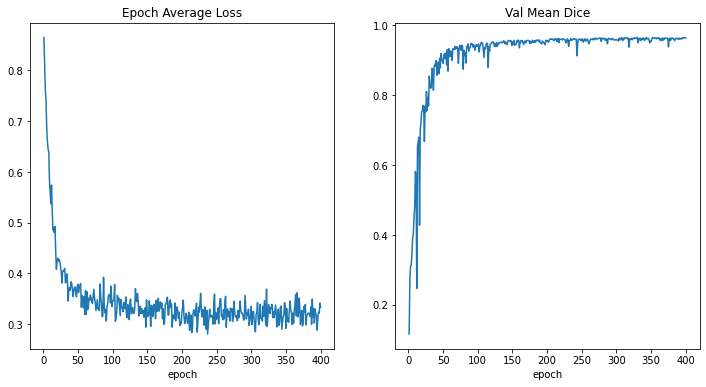

In [18]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

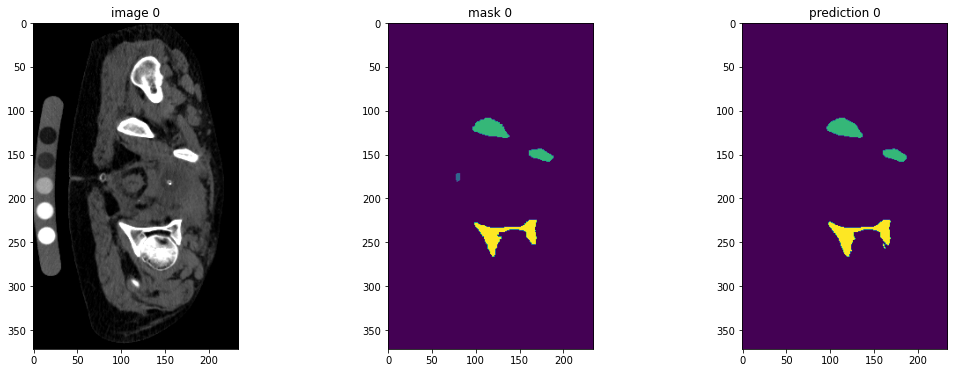

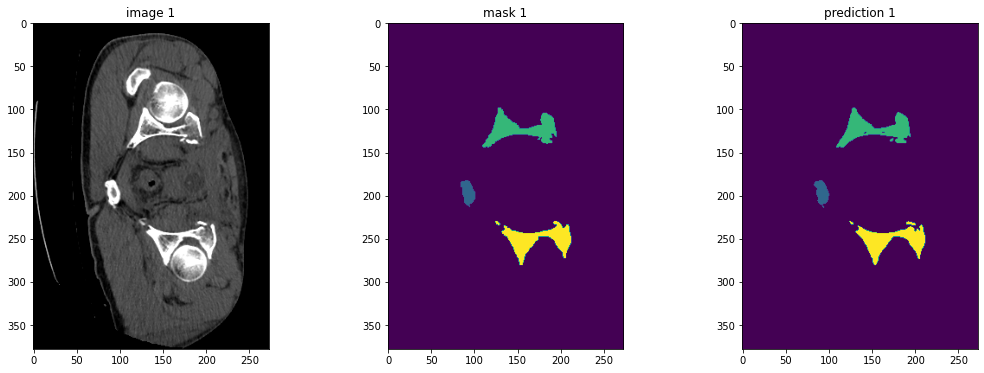

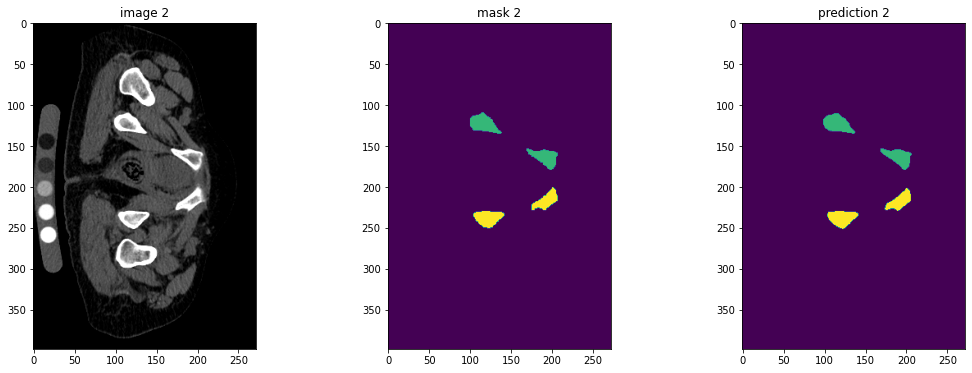

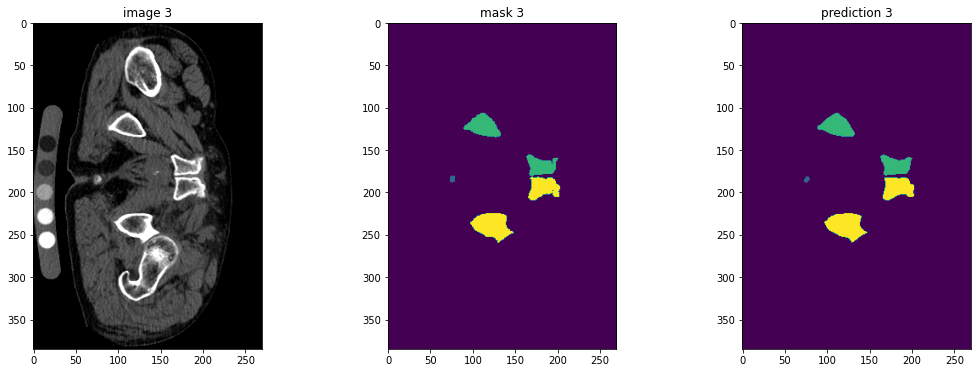

In [19]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        
        val_inputs = val_data["image"].to(device)
        val_outputs = inference(val_inputs)
        
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        
        plt.subplot(1, 3, 2)
        plt.title(f"mask {i}")
        plt.imshow(val_data["mask"][0, 0, :, :, 80])
        
        plt.subplot(1, 3, 3)
        plt.title(f"prediction {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        
        plt.show()
        if i == 3:
            break

## Inference Evaluation of Model

In [20]:
test_image = os.path.join(root_dir, 'test_images')
test_images = sorted(glob.glob(os.path.join(test_image, "*data.nii.gz")))
images_dicts = [{"image": image_name} for image_name in test_images]
test_images = images_dicts[:]

In [21]:
test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        ScaleIntensityRanged(keys=["image"], a_min=-120, a_max=360,b_min=0.0, b_max=1.0, clip=True,),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys="image"),
    ]
)   

In [23]:
test_org_ds = CacheDataset(data=test_images, transform=test_org_transforms, cache_rate=1.0, num_workers=0)
test_loader = DataLoader(test_org_ds, batch_size=1, num_workers=0)

# test_org_ds = Dataset(data=test_data, transform=test_org_transforms)
# test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.19s/it]


In [24]:
post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=5),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
])

In [25]:
from monai.transforms import LoadImage
loader = LoadImage()

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model,sw_device="cuda:0", device="cpu")
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_output = from_engine(["pred"])(test_data)
        

2022-03-04 05:24:53,555 INFO image_writer.py:190 - writing: out\dataset6_CLINIC_0006_data\dataset6_CLINIC_0006_data_seg.nii.gz
2022-03-04 05:25:27,328 INFO image_writer.py:190 - writing: out\dataset6_CLINIC_0009_data\dataset6_CLINIC_0009_data_seg.nii.gz
2022-03-04 05:25:59,024 INFO image_writer.py:190 - writing: out\dataset6_CLINIC_0015_data\dataset6_CLINIC_0015_data_seg.nii.gz
2022-03-04 05:26:31,031 INFO image_writer.py:190 - writing: out\dataset6_CLINIC_0029_data\dataset6_CLINIC_0029_data_seg.nii.gz
2022-03-04 05:27:06,288 INFO image_writer.py:190 - writing: out\dataset6_CLINIC_0031_data\dataset6_CLINIC_0031_data_seg.nii.gz


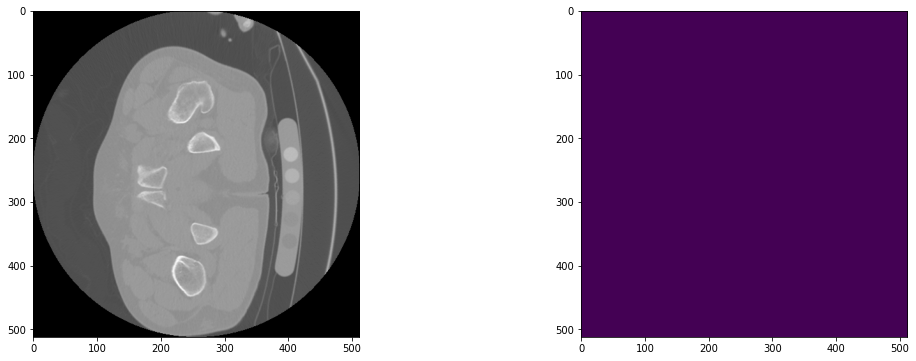

In [26]:
original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

plt.figure("check", (18, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(test_output[0].detach().cpu()[1, :, :, 80])

plt.show()

## Evaluation of Model on original image spacing

In [27]:
test_image = os.path.join(root_dir, 'test_images')
test_mask = os.path.join(root_dir, 'test_masks')

In [28]:
test_images = sorted(glob.glob(os.path.join(test_image, "*data.nii.gz")))
test_labels = sorted(glob.glob(os.path.join(test_mask , "*mask_4label.nii.gz")))

test_dicts = [ {"image": image_name, "mask": label_name} for image_name, label_name in zip(test_images, test_labels) ]
test_files = test_dicts[:]

In [29]:
test_transforms = Compose([
    
        LoadImaged(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),
        Orientationd(keys=["image", "mask"], axcodes="RAS"),
        #Spacingd(keys=["image", "mask"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear")),
        ScaleIntensityRanged(keys=["image"], a_min=-120, a_max=360,b_min=0.0, b_max=1.0, clip=True,),
        #CropForegroundd(keys=["image", "mask"], source_key="image"),
        EnsureTyped(keys=["image", "mask"]),
    ])


In [30]:
# test_ds = Dataset(data=test_files, transform=test_transforms)
# test_loader  = DataLoader(test_ds, batch_size=1, num_workers=0)

test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=0)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.64s/it]


In [31]:
post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(keys="pred", transform=test_transforms, orig_keys="image", meta_keys="pred_meta_dict", 
            orig_meta_keys="image_meta_dict", meta_key_postfix="meta_dict", nearest_interp=False,to_tensor=True,),
    AsDiscreted(keys="pred", argmax=True, to_onehot=5),
    AsDiscreted(keys="mask", to_onehot=5),
])

In [32]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

model.eval()
with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model,sw_device="cuda:0", device="cpu")
        #uses cuda to run network(window_data) and uses cpu memory to store the final predicted volume
        
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_outputs, test_labels = from_engine(["pred", "mask"])(test_data)
        
        # compute metric for current iteration
        dice_metric(y_pred=test_outputs, y=test_labels)

    # aggregate the final mean dice result
    metric_test = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_test)

#test_data["pred"] = inference(test_inputs)


Metric on original image spacing:  0.06297102570533752
